In [2]:
from qutip import *
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def print_gadget(gadget):
    # Build and print the tensor representation
    tensor_representation = []
    for op in gadget:
        # Check for identity
        if op == I:
            tensor_representation.append("I")
        # Check for standard operators
        elif op == X:
            tensor_representation.append("X")
        elif op == Z:
            tensor_representation.append("Z")
        elif op == Y:
            tensor_representation.append("Y")
        # Check for 0.5(I - Z)
        elif (
            isinstance(op, Qobj)  # Ensure it's a Qobj
            and op.dims == I.dims  # Match single-qubit operator dimensions
            and np.allclose(op.full(), (0.5 * I - 0.5 * Z).full())  # Compare matrices
        ):
            tensor_representation.append("1/2(I-Z)")
        # Fallback for unknown operators
        else:
            tensor_representation.append("Unknown")
    
    print(f"tensor({', '.join(tensor_representation)})")

In [80]:
# Define basic operators
I = qeye(2)
X = sigmax()
Y = sigmay()
Z = sigmaz()

# Define stabilizer generators for the 4-qubit code
X_L = [Y, I, Y, I]
Z_L = [Z, Z, I, I]
g1_ops = [X, X, X, X]
g2_ops = [Z, Z, Z, Z]
g3_ops = [X, Y, Z, I]

hs = [g1_ops,g2_ops,g3_ops]


# Parameters
total_logic_qbits = 4  # Number of logical qubits

ks = [sum(1 for op in operator if op != I) for operator in hs]  # Auxiliary qubits for each stabilizer
tot_space = total_logic_qbits + sum(ks)

# Initialize the total Hamiltonian
# H_gad = tensor([Qobj(np.zeros((2, 2))) for _ in range(tot_space)])  # Start with a zero operator
H_gad = 0

# Build auxiliary Hamiltonians and embed them
current_position = total_logic_qbits  # Start after logical qubits
for index, operator in enumerate(hs):
    k = sum(1 for op in operator if op != I)    
    print(k)
    
    ######## H_aux ############
    print("H_aux")
    for j in range(k):
        Z_i = tensor([Z if j == i else I for i in range(k)])
        aux_H = 0.5 * (tensor([0.5 * (I - (Z if j  == i else I)) for i in range(k)]))
        
        # Embed aux_H into the full space
        pre_space = [I for _ in range(current_position)]  # Identities before this auxiliary block
        post_space = [I for _ in range(tot_space - current_position - k)]  # Identities after this block    
        full_aux_H = tensor(pre_space + [aux_H] + post_space)    
    ######## H_aux ############


        ####### FOR PRINTING Aux #######
        to_p = (
            pre_space
            + [0.5 * (I - (Z if j  == i else I)) for i in range(k)]
            + post_space
        )
        print_gadget(to_p)
        ####### FOR PRINTING Aux #######
        
    perturbation_factor = 0.45401
    
    print("V_pert")
    # Now adding the perturbative terms
    for j, op in enumerate(operator):
        if op == I:
            continue     
        

        ######## V ############
        logical_operator = tensor(
            [op if i == j else I for i in range(total_logic_qbits)]
        )
        
        # Auxiliary space for this stabilizer
        # auxiliary_operator = tensor([X if i == (j % k) else X if i == (j + 1) % k else I for i in range(k)])
        auxiliary_operator = tensor([X if i == (j % k) else I for i in range(k)])
        
        # Embed auxiliary operator into the full auxiliary space
        pre_aux = [I for _ in range(current_position - total_logic_qbits)]  # Identities for earlier stabilizers
        post_aux = [I for _ in range(sum(ks[index + 1:]))]  # Identities for remaining stabilizers
        full_auxiliary_operator = tensor(pre_aux + [auxiliary_operator] + post_aux)
        
        # Combine logical and full auxiliary operators
        full_v = tensor(logical_operator, full_auxiliary_operator)
        ######## V ############
                

        ####### FOR PRINTING V #######
        # to_p = [op if i == j else I for i in range(total_logic_qbits)] + pre_aux + [X if i == (j % k) else X if i == (j + 1) % k else I for i in range(k)] + post_aux
        to_p = [op if i == j else I for i in range(total_logic_qbits)] + pre_aux + [X if i == (j % k) else I for i in range(k)] + post_aux
        
        print_gadget(to_p)
        ####### FOR PRINTING V #######
        
        
        H_gad += perturbation_factor * full_v + full_aux_H

    
    current_position += k
    print()
    

print("Total Hamiltonian Dimensions:", H_gad.dims)

4
H_aux
tensor(I, I, I, I, 1/2(I-Z), I, I, I, I, I, I, I, I, I, I)
tensor(I, I, I, I, I, 1/2(I-Z), I, I, I, I, I, I, I, I, I)
tensor(I, I, I, I, I, I, 1/2(I-Z), I, I, I, I, I, I, I, I)
tensor(I, I, I, I, I, I, I, 1/2(I-Z), I, I, I, I, I, I, I)
V_pert
tensor(X, I, I, I, X, I, I, I, I, I, I, I, I, I, I)
tensor(I, X, I, I, I, X, I, I, I, I, I, I, I, I, I)
tensor(I, I, X, I, I, I, X, I, I, I, I, I, I, I, I)
tensor(I, I, I, X, I, I, I, X, I, I, I, I, I, I, I)

4
H_aux
tensor(I, I, I, I, I, I, I, I, 1/2(I-Z), I, I, I, I, I, I)
tensor(I, I, I, I, I, I, I, I, I, 1/2(I-Z), I, I, I, I, I)
tensor(I, I, I, I, I, I, I, I, I, I, 1/2(I-Z), I, I, I, I)
tensor(I, I, I, I, I, I, I, I, I, I, I, 1/2(I-Z), I, I, I)
V_pert
tensor(Z, I, I, I, I, I, I, I, X, I, I, I, I, I, I)
tensor(I, Z, I, I, I, I, I, I, I, X, I, I, I, I, I)
tensor(I, I, Z, I, I, I, I, I, I, I, X, I, I, I, I)
tensor(I, I, I, Z, I, I, I, I, I, I, I, X, I, I, I)

3
H_aux
tensor(I, I, I, I, I, I, I, I, I, I, I, I, 1/2(I-Z), I, I)
tensor(I, I, 

In [76]:
X_L = tensor(Y, I, Y, I)
Z_L = tensor(Z, Z, I, I)
Y_L = -tensor(I, X, X, I)

basis_states = [basis(2, 0), basis(2, 1)]

# Define the logical zero state |0_L>
logical_zero = (tensor(basis_states[0], basis_states[0], basis_states[0], basis_states[0]) +
                1j*tensor(basis_states[0], basis_states[0], basis_states[1], basis_states[1]) +
                1j*tensor(basis_states[1], basis_states[1], basis_states[0], basis_states[0]) +
                tensor(basis_states[1], basis_states[1], basis_states[1], basis_states[1])).unit()

logical_one = X_L * logical_zero

In [77]:
# RAP time-dependent terms
T = 100
t = np.linspace(0, T, 1000)
sigma = 1
omega_max = 50
omega_t = omega_max * np.exp(-0.5 * ((t - T/2) / sigma) ** 2)
delta_t = 2 * omega_max * (t / (T / 2) - 1)

# Modified H_S_0 with gadgets
H_p_gad = - 100 * H_gad  # Replace original H_p with gadgetized version

# Expanding the space of the one local operations of the RAP to the new space
X_L_all = tensor(X_L, tensor([I for _ in range(sum(ks))]))
Z_L_all = tensor(Z_L, tensor([I for _ in range(sum(ks))]))
H_S_0_gad = omega_t[0] * X_L_all + delta_t[0] * Z_L_all + H_p_gad

# Diagonalize the modified Hamiltonian
eigenvalues_0, eigenstates_0 = H_S_0_gad.eigenstates(sparse=True, eigvals=1)

# Print eigenvalues to confirm
print("Eigenvalues of H_S_0 with gadgets:", eigenvalues_0)



Eigenvalues of H_S_0 with gadgets: [-399.99670682]


In [78]:
g1 = tensor(X, X, X, X)
g2 = tensor(Z, Z, Z, Z)
g3 = tensor(X, Y, Z, I)
H_p = -100*(g1 + g2 + g3)

H_S_0 = omega_t[0] * X_L + delta_t[0] * Z_L + H_p

# Diagonalize the modified Hamiltonian
eigenvalues_0, eigenstates_0 = H_S_0.eigenstates()

# Print eigenvalues to confirm
print("Eigenvalues of H_S_0 with gadgets:", eigenvalues_0[0])

Eigenvalues of H_S_0 with gadgets: -399.99999999999966


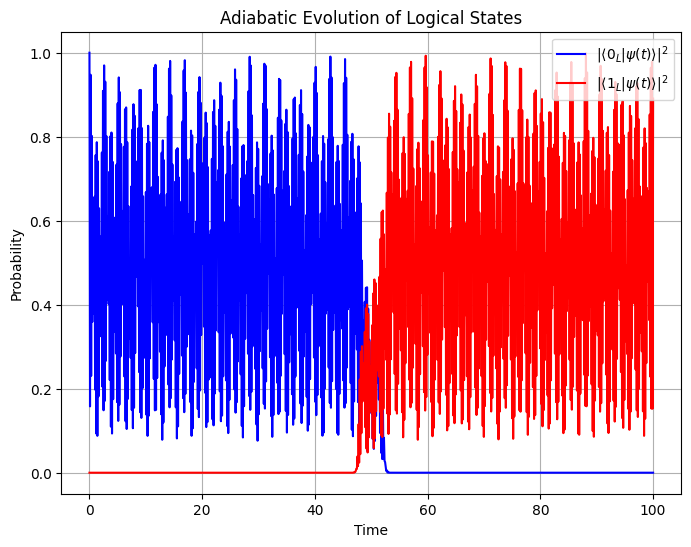

In [32]:
# Define logical states |0_L> and |1_L>
basis_states = [basis(2, 0), basis(2, 1)]

# Define the 4-qubit logical zero state |0_L>
logical_zero_4q = (tensor(basis_states[0], basis_states[0], basis_states[0], basis_states[0]) +
                   1j * tensor(basis_states[0], basis_states[0], basis_states[1], basis_states[1]) +
                   1j * tensor(basis_states[1], basis_states[1], basis_states[0], basis_states[0]) +
                   tensor(basis_states[1], basis_states[1], basis_states[1], basis_states[1])).unit()

# Extend |0_L> to 7 qubits by tensoring with auxiliary qubits in |0>
auxiliary_qubits = tensor(basis_states[0], basis_states[0], basis_states[0])  # Auxiliary qubits in |0>
logical_zero = tensor(logical_zero_4q, auxiliary_qubits)
logical_one = X_L * logical_zero


# Define time-dependent Hamiltonian
def H_RAP(t, args):
    omega_t = args['omega_max'] * np.exp(-0.5 * ((t - args['T'] / 2) / args['sigma']) ** 2)
    delta_t = 2 * args['omega_max'] * (t / (args['T'] / 2) - 1)
    return omega_t * X_L + delta_t * Z_L + H_gadget



P_zero = logical_zero * logical_zero.dag()
P_one = logical_one * logical_one.dag()


# Solve the system with sesolve
args = {'omega_max': omega_max, 'T': T, 'sigma': sigma}
H_td = QobjEvo(H_RAP, args=args)
result = sesolve(H_td, logical_zero, t, [P_zero, P_one])

# Extract probabilities
p_zero = result.expect[0]
p_one = result.expect[1]

# Plot the results
plt.figure(figsize=(8, 6))
plt.plot(t, p_zero, label=r'$| \langle 0_{L} | \psi(t) \rangle |^2$', color='blue')
plt.plot(t, p_one, label=r'$| \langle 1_{L} | \psi(t) \rangle |^2$', color='red')
plt.xlabel('Time')
plt.ylabel('Probability')
plt.title('Adiabatic Evolution of Logical States')
plt.legend(loc='upper right')
plt.grid()
plt.show()
